##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved. 

The dataset is downloaded from the public docket at: 
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [12]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [13]:
orig_df = pd.read_csv('../../datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [14]:
df = pd.read_csv('../../datasets/LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [15]:

df['X'] = df['X'] 
df['Y'] = df['Y'] 
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [16]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [17]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means. 
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data? 


In [18]:
df.head(10)

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
0,-115.087518,36.216702,0,0,0,0,0
1,-115.240172,36.189693,1,1,1,1,0
2,-115.143088,36.181329,2,1,2,0,1
3,-115.225014,36.117633,3,1,1,2,2
4,-115.176708,36.095967,4,1,1,3,0
5,-115.132162,36.100841,5,1,3,4,1
6,-115.176012,36.194067,1,1,4,5,2
7,-115.194061,36.135213,3,1,4,3,1
8,-115.069716,36.191304,0,1,5,6,0
9,-115.309341,36.074367,6,1,6,1,0


# Description of each row in df
1. X = This gives us the latitude of the crime
2. Y = This gives us the longitude of the crime
3. Area_Command = This is the Label Encoded data for the Police Station that is under command of the area where the crime was reported
4. NIBRSOffenseCode = This is the Label Encoded data for the Offense Committed
5. DayOfWeek = This is the Label Encoded data for the day on which the crime was committed (0 = Sunday, 1 = Monday, and so on)
6. Time = This shows the time of the day when the crime was committed, the hour of the day
7. VictimCount = This shows the integer number of the victims caused by the crime


##### Input Variables = X, Y, Area_Command, NIBRSOffenseCode, DayOfWeek, Time
##### Target Variable = VictimCount

##### As the longitude and lattitude are already in a fixed range, there is no need to normalize it further.
##### And all the other data is categorical data, so they might be factorized or encoded, so they also dont need any normalization

In [11]:
summary = df.describe()
column_ranges = summary.loc[['min', 'max']]
column_ranges

,X,Y,Area_Command,NIBRSOffenseCode,DayOfWeek,Time,VictimCount
min,-116.00000,35.068419,0.0,0.0,0.0,0.0,0.0
max,-114.62557,37.000000,11.0,2.0,6.0,23.0,6.0


## Task 2 

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data. 

In [20]:
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

# Splitting the data into features and target
features = df.drop('VictimCount', axis=1)
target = df['VictimCount']

# Dividing the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Creating custom dataset classes for training and testing
class CrimeDataset(Dataset):
    def __init__(self, features, target):
        self.features = torch.tensor(features.values, dtype=torch.float32)
        self.target = torch.tensor(target.values, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.target[idx]

# Creating dataset objects for training and testing
train_dataset = CrimeDataset(X_train, y_train)
test_dataset = CrimeDataset(X_test, y_test)

# Creating DataLoader objects for training and testing
batch_size = 64  # You can adjust this based on your computational resources
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verifying the shape of data by iterating over the training dataset and printing the shape of the batched data
for batch in train_loader:
    features_batch, target_batch = batch
    print("Features batch shape:", features_batch.shape)
    print("Target batch shape:", target_batch.shape)
    break  # Break after printing the first batch shape to avoid long output


Features batch shape: torch.Size([64, 6])
Target batch shape: torch.Size([64])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem. 

* Define the proper loss function for this task
##### -> Ans - For a regression problem the loss function used is Mean Squared Error (MSE) Loss
* what should the size of the predicted output be?
##### -> Ans - Here the size of the output should be 1 because of this being a regression problem where we are predicting the victim count
* explain your choice of architecture, including how many layers you will be using
##### -> Ans - I have gone with a feedforward neural network with four fully connected layers 
#####      1. Input Layer - The size of the layer is equal to that of the input size
#####      2. Hidden Layers - There are 3 layers with the size equal to hidden_size(64)
#####      3. Output Layer - The final layer has size of 1, that is predicting the VictimCount
* define an optimizer for training this model, choose a proper learning rate 
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it. 

In [51]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network architecture
# class CrimeNet(nn.Module):
#     def __init__(self, input_size, hidden_size):
#         super(CrimeNet, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_size, hidden_size)
#         self.fc3 = nn.Linear(hidden_size, 1)  # Output size is 1 for regression

#     def forward(self, x):
#         x = self.relu(self.fc1(x))
#         x = self.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# # Changing the architecture
# class CrimeNet(nn.Module):
#     def __init__(self, input_size, hidden_size):
#         super(CrimeNet, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_size, hidden_size)
#         self.fc3 = nn.Linear(hidden_size, hidden_size)  # Adding another hidden layer
#         self.fc4 = nn.Linear(hidden_size, 1)

#     def forward(self, x):
#         x = self.relu(self.fc1(x))
#         x = self.relu(self.fc2(x))
#         x = self.relu(self.fc3(x))  # Applying ReLU to the third hidden layer
#         x = self.fc4(x)
#         return x


# # Changing the activating function
# class CrimeNet(nn.Module):
#     def __init__(self, input_size, hidden_size):
#         super(CrimeNet, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.activation = nn.Tanh()  # Using Tanh activation function
#         self.fc2 = nn.Linear(hidden_size, hidden_size)
#         self.fc3 = nn.Linear(hidden_size, 1)

#     def forward(self, x):
#         x = self.activation(self.fc1(x))
#         x = self.activation(self.fc2(x))
#         x = self.fc3(x)
#         return x

# Changing both the activation function and the architecture
class CrimeNet(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CrimeNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.tanh = nn.Tanh()  # Using Tanh activation function
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.fc4(x)
        return x


# Initialize the model, loss function, and optimizer
input_size = X_train.shape[1]
hidden_size = 64  # You can adjust this
model = CrimeNet(input_size, hidden_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00389)


# Training loop
num_epochs = 15  # Adjust as needed
for epoch in range(num_epochs):
    model.train()
    for features, target in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, target.unsqueeze(1))  # Ensure target is the correct shape
        loss.backward()
        optimizer.step()

    # Calculate MSE on test data
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for features, target in test_loader:
            outputs = model(features)
            loss = criterion(outputs, target.unsqueeze(1))
            total_loss += loss.item()
    mse = total_loss / len(test_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}], MSE: {mse:.4f}')

# Adjust the learning rate, hidden size, and other parameters to optimize performance


Epoch [1/15], MSE: 0.9279
Epoch [2/15], MSE: 0.9380
Epoch [3/15], MSE: 0.9768
Epoch [4/15], MSE: 0.9492
Epoch [5/15], MSE: 0.9441
Epoch [6/15], MSE: 0.9371
Epoch [7/15], MSE: 0.9364
Epoch [8/15], MSE: 0.9315
Epoch [9/15], MSE: 0.9332
Epoch [10/15], MSE: 0.9312
Epoch [11/15], MSE: 0.9394
Epoch [12/15], MSE: 0.9308
Epoch [13/15], MSE: 0.9346
Epoch [14/15], MSE: 0.9342
Epoch [15/15], MSE: 0.9356


## Task 4 

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem. 

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
##### -> Ans - Just get the number of unique values in the crime victims data
* How is the architecture different?
##### -> Ans - Here the architecture is 
#####         1. Input Layer - the input layer 
#####         2. Hidden Layer - 2 hidden layer
#####         3. Output Layer - 1 output layer
* How is the loss function different?
##### -> Ans - The loss function used for classification problem is Cross Entropy Loss, this is the loss usually used for multi-class classification problem
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get? 

In [22]:
num_classes = df['VictimCount'].nunique()
print("Number of classes:", num_classes)

Number of classes: 7


In [188]:
import torch
import torch.nn as nn
import torch.optim as optim

# # Define the neural network architecture for classification
# class CrimeNetClassification(nn.Module):
#     def __init__(self, input_size, hidden_size, num_classes):
#         super(CrimeNetClassification, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_size, hidden_size)
#         self.fc3 = nn.Linear(hidden_size, num_classes)  # Output size is num_classes for classification

#     def forward(self, x):
#         x = self.relu(self.fc1(x))
#         x = self.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# # Changing the activation function
# class CrimeNetClassificationVariation1(nn.Module):
#     def __init__(self, input_size, hidden_size, num_classes):
#         super(CrimeNetClassificationVariation1, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.sigmoid = nn.Sigmoid()  # Use Sigmoid activation function
#         self.fc2 = nn.Linear(hidden_size, hidden_size)
#         self.fc3 = nn.Linear(hidden_size, num_classes)

#     def forward(self, x):
#         x = self.sigmoid(self.fc1(x))
#         x = self.sigmoid(self.fc2(x))
#         x = self.fc3(x)
#         return x

# # Changing the number of hidden layers
# class CrimeNetClassificationVariation2(nn.Module):
#     def __init__(self, input_size, hidden_size, num_classes):
#         super(CrimeNetClassificationVariation2, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_size, hidden_size)
#         self.fc3 = nn.Linear(hidden_size, hidden_size)  # Adding an additional hidden layer
#         self.fc4 = nn.Linear(hidden_size, num_classes)

#     def forward(self, x):
#         x = self.relu(self.fc1(x))
#         x = self.relu(self.fc2(x))
#         x = self.relu(self.fc3(x))
#         x = self.fc4(x)
#         return x



# Initialize the model, loss function, and optimizer for classification
input_size = X_train.shape[1]
hidden_size = 64  # You can adjust this
model = CrimeNetClassification(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002)  # Adjust learning rate as needed

# Training loop for classification
num_epochs = 20  # Adjust as needed
for epoch in range(num_epochs):
    model.train()
    for features, target in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, target.long())  # Ensure target is the correct data type
        loss.backward()
        optimizer.step()

    # Calculate accuracy on test data
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for features, target in test_loader:
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.2f}%')

# Adjust the learning rate, hidden size, and other parameters to optimize performance

Epoch [1/20], Accuracy: 54.55%
Epoch [2/20], Accuracy: 54.55%
Epoch [3/20], Accuracy: 49.09%
Epoch [4/20], Accuracy: 54.55%
Epoch [5/20], Accuracy: 38.18%
Epoch [6/20], Accuracy: 54.55%
Epoch [7/20], Accuracy: 54.55%
Epoch [8/20], Accuracy: 50.91%
Epoch [9/20], Accuracy: 54.55%
Epoch [10/20], Accuracy: 60.00%
Epoch [11/20], Accuracy: 54.55%
Epoch [12/20], Accuracy: 58.18%
Epoch [13/20], Accuracy: 56.36%
Epoch [14/20], Accuracy: 54.55%
Epoch [15/20], Accuracy: 40.00%
Epoch [16/20], Accuracy: 54.55%
Epoch [17/20], Accuracy: 54.55%
Epoch [18/20], Accuracy: 54.55%
Epoch [19/20], Accuracy: 54.55%
Epoch [20/20], Accuracy: 56.36%


## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
##### -> Ans - Based on the data from the task 3 and 4 we can see that the MSE loss remained almost consistent around 0.93 while that for the accuracy in task 4 the accuracy was fluctuating over each epoch. Thus taking consistency as a desirable trait and also the fact that the prediction of Victim Count feels like a regression problem and task 3 is predicting the number of victims in a crime, thus it is a more natural way of solving the problem rather than classifying the number of victims as a class. Thus on the basis of this task 3 that is the regression task performed better.
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

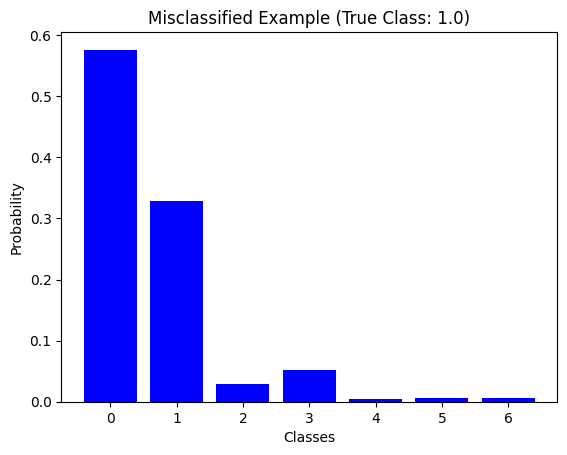

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Function to find a misclassified example and plot probabilities
def find_misclassified_example(model, data_loader):
    model.eval()
    with torch.no_grad():
        for features, target in data_loader:
            outputs = model(features)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)
            misclassified_indices = (predicted != target)
            
            if any(misclassified_indices):
                misclassified_idx = np.where(misclassified_indices.numpy())[0][0]
                misclassified_features = features[misclassified_idx]
                misclassified_target = target[misclassified_idx].item()
                misclassified_probs = probabilities[misclassified_idx].numpy()
                
                # Plotting the probabilities in a bar chart
                plt.bar(range(len(misclassified_probs)), misclassified_probs, color='blue')
                plt.xlabel('Classes')
                plt.ylabel('Probability')
                plt.title(f'Misclassified Example (True Class: {misclassified_target})')
                plt.show()
                break

# Find and plot a misclassified example
find_misclassified_example(model, test_loader)


## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


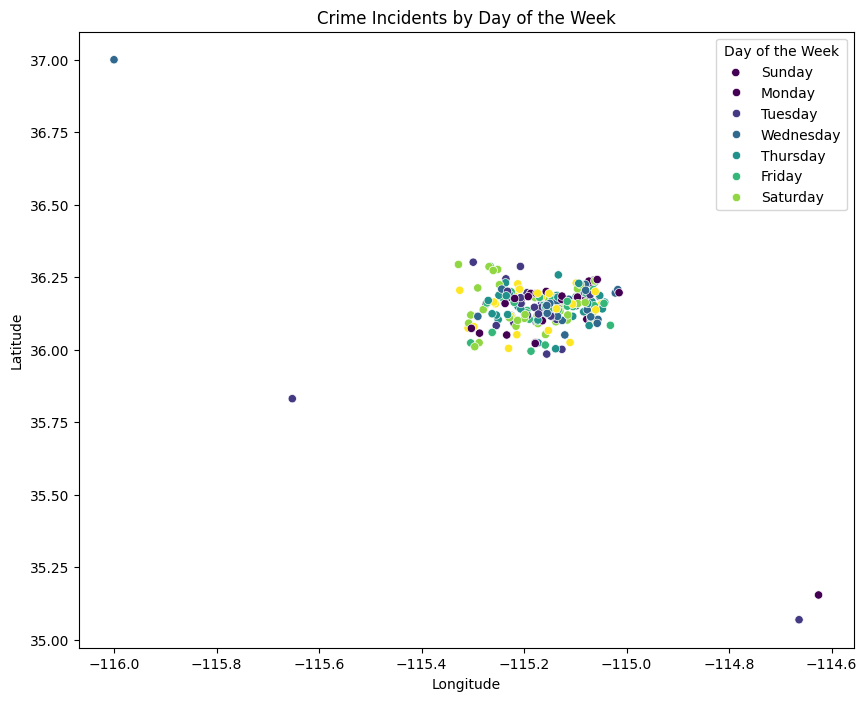

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter Plot of Crime Incidents by Day of the Week
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='X', y='Y', hue='DayOfWeek', palette='viridis', legend='full')
plt.title('Crime Incidents by Day of the Week')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Day of the Week', labels=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'])
plt.show()

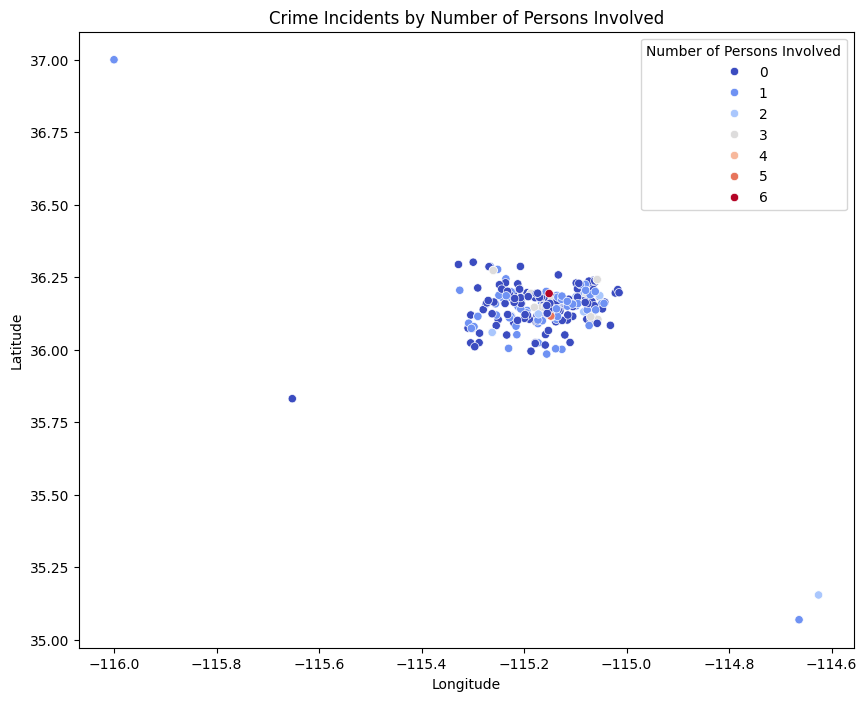

In [26]:
# Scatter Plot of Crime Incidents by Number of Persons Involved
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='X', y='Y', hue='VictimCount', palette='coolwarm', legend='full')
plt.title('Crime Incidents by Number of Persons Involved')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Number of Persons Involved')
plt.show()

In [27]:
# Sort the number of crimes reported by the day of the week
crime_count_by_day = df['DayOfWeek'].value_counts().sort_values(ascending=False)

# Map the numerical values to day names
day_mapping = {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}
crime_count_by_day = crime_count_by_day.rename(index=day_mapping)

crime_count_by_day

DayOfWeek
Thursday     51
Wednesday    44
Friday       43
Sunday       40
Monday       37
Tuesday      32
Saturday     28
Name: count, dtype: int64